# Hand Crafted Stochastic Model

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.20.3


## First Step: Load Data and disassemble for our purposes

In [4]:
df = pd.read_csv('./insurance-customers-300.csv', sep=';')

In [5]:
y=df['group']

In [6]:
df.drop('group', axis='columns', inplace=True)

In [7]:
X = df.as_matrix()

In [8]:
df.describe()

,max speed,age,thousand km per year
count,300.000000,300.000000,300.000000
mean,171.863333,44.006667,31.220000
std,18.807545,16.191784,15.411792
min,132.000000,18.000000,5.000000
25%,159.000000,33.000000,18.000000
50%,171.000000,42.000000,30.000000
75%,187.000000,52.000000,43.000000
max,211.000000,90.000000,99.000000


## Second Step: Expressing Known Facts as (Normal) Distributions

In [16]:
from scipy.stats import norm

### Distributions over Age

Text(0.5,0,'Age')

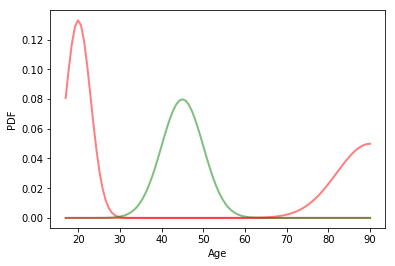

In [22]:
age_threshold = 0.01
ages = np.linspace(17, 90, 100)

def is_young(age):
    return norm.pdf(age, loc=20, scale=3)

def good_age(age):
    return norm.pdf(age, loc=45, scale=5)

def is_old(age):
    return norm.pdf(age, loc=90, scale=8)

plt.plot(ages, is_young(ages), 'r', lw=2, alpha=0.5)
plt.plot(ages, good_age(ages), 'g', lw=2, alpha=0.5)
plt.plot(ages, is_old(ages), 'r', lw=2, alpha=0.5)

plt.ylabel('PDF')
plt.xlabel('Age')

### Distributions over Kilometers per Year

Text(0.5,0,'thousand km per year')

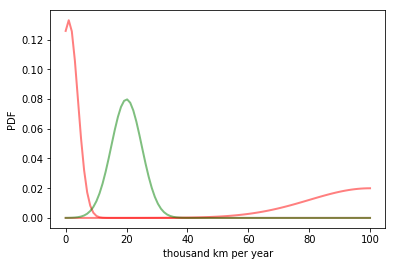

In [23]:
kms = np.linspace(0, 100, 100)
kms_threshold = 0.005

def no_practice(km):
    return norm.pdf(km, loc=1, scale=3)

def much_driving(km):
    return norm.pdf(km, loc=100, scale=20)

def sweet_spot(km):
    return norm.pdf(km, loc=20, scale=5)

plt.plot(kms, no_practice(kms), 'r', lw=2, alpha=0.5)
plt.plot(kms, much_driving(kms), 'r', lw=2, alpha=0.5)
plt.plot(kms, sweet_spot(kms), 'g', lw=2, alpha=0.5)

plt.ylabel('PDF')
plt.xlabel('thousand km per year')

### Distributions over speed

Text(0.5,0,'km/h')

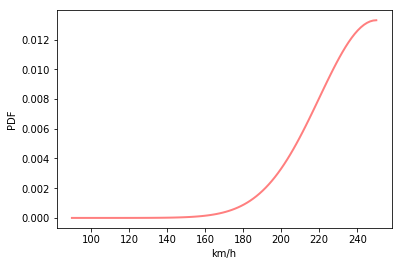

In [24]:
kmhs = np.linspace(90, 250, 100)
kmhs_threshold = 0.002

def too_fast(kmh):
    return norm.pdf(kmh, loc=250, scale=30)

plt.plot(kmhs, too_fast(kmhs), 'r', lw=2, alpha=0.5)

plt.ylabel('PDF')
plt.xlabel('km/h')

## Third Step: Creating a combined Model from Distributions

In [21]:
# ignore this, it is just technical code
# should come from a lib, consider it to appear magically 
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#AAAA00'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, colors, title="", mesh=True, fname=None):
    xx,yy = meshGrid(x_data, y_data)
    plt.figure(figsize=(20,10))

    if clf and mesh:
        Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    if fname:
        plt.scatter(x_data, y_data, c=colors, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        plt.scatter(x_data, y_data, c=colors, cmap=cmap_bold, s=80, marker='o', edgecolors='k')
    plt.xlabel(x_label, fontsize=font_size)
    plt.ylabel(y_label, fontsize=font_size)
    plt.title(title, fontsize=font_size)
    if fname:
        plt.savefig(fname)

In [25]:
# 0: red
# 1: green
# 2: yellow

class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

age_factor = 1
kmhs_factor = 10
kms_factor = 0.5

def scoring(x):
    speed, age, km_per_year = x
    pos_score = good_age(age) * age_factor + sweet_spot(km_per_year) * kms_factor
    neg_score = (is_young(age) * age_factor + is_old(age) * age_factor
        + too_fast(speed) * kmhs_factor
        + no_practice(km_per_year) * kms_factor + much_driving(km_per_year) * kms_factor)
    return pos_score - neg_score

score_threshold = 0.01

def predict_for_score(x):
    score = scoring(x)
    if abs(score) < score_threshold:
        return 2
    if score < 0:
        return 0
    return 1

class ScoringStatsClassifier(ClassifierBase):
    def predict_single(self, x):
        try:
            speed, age, km_per_year = x
        except:
            speed, age = x
            km_per_year = 40
        return predict_for_score([speed, age, km_per_year])

In [26]:
clf = ScoringStatsClassifier()

In [28]:
clf.score(X, y)

0.53

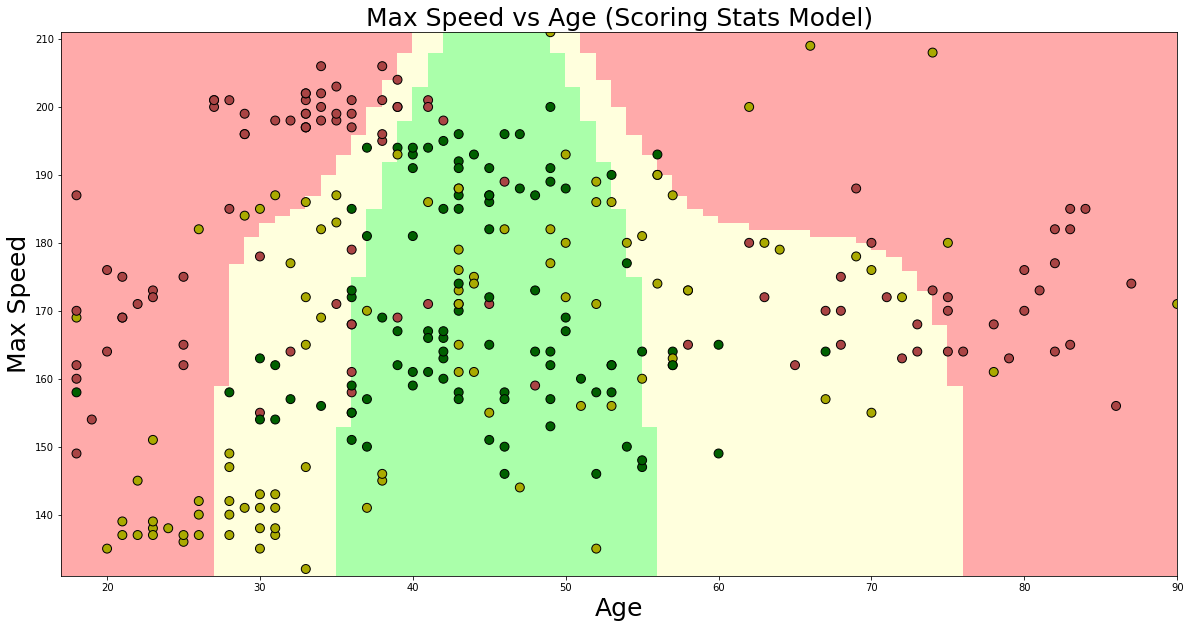

In [30]:
plotPrediction(clf, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="Max Speed vs Age (Scoring Stats Model)")